# [A Regret Minimization Approach to Iterative Learning Control](https://arxiv.org/pdf/2102.13478.pdf )

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
from deluca.igpc.ilqr import iLQR
from deluca.envs import PlanarQuadrotor

### System - Planar Quadrotor with wind ([deluca implementation](https://github.com/google/deluca/blob/main/deluca/envs/classic/_planar_quadrotor.py))
### Algorithms Compared
* **Closed Loop ILQG** - [Li,Todorov](https://homes.cs.washington.edu/~todorov/papers/LiICINCO04.pdf) ([deluca implementation](https://github.com/MinRegret/deluca-igpc/blob/main/deluca/igpc/ilqr.py))

* **iLC - Iterative Learning Control** [Abeel et al.](https://ai.stanford.edu/~ang/papers/icml06-usinginaccuratemodelsinrl.pdf) ([deluca implementation](https://github.com/MinRegret/deluca-igpc/blob/main/deluca/igpc/ilc.py))

* **iGPC - Iterative GPC** [Agarwal et. al.](https://arxiv.org/abs/2102.13478) ([deluca implementation](https://github.com/MinRegret/deluca-igpc/blob/main/deluca/igpc/igpc.py)

In [3]:
def cost(x, u, sim):
    return 0.1 * (u - sim.goal_action) @ (u - sim.goal_action) + (x.arr - sim.goal_state) @ (x.arr - sim.goal_state)

env_true, env_sim = PlanarQuadrotor.create(wind=0.4), PlanarQuadrotor.create()
#Initial actions
U0 = jnp.tile(env_sim.goal_action, (env_sim.H, 1))
# Warm up with either file or iLQR
warmup_steps = 8
X, U, k, K, c = iLQR(env_sim, cost, U0, warmup_steps, verbose=True)

iLQR (true): t = -1, r = 1, c = 199.99996948242188
iLQR (true): t = 0, r = 2, alphac = 0.550000011920929, cost = 89.76985931396484
iLQR (true): t = 0, r = 2, c = 89.76985931396484
iLQR (true): t = 1, r = 3, alphac = 0.6050000190734863, cost = 60.330223083496094
iLQR (true): t = 1, r = 3, c = 60.330223083496094
iLQR (true): t = 2, r = 4, alphac = 0.6655000448226929, cost = 53.9387321472168
iLQR (true): t = 2, r = 4, c = 53.9387321472168
iLQR (true): t = 3, r = 5, alphac = 0.7320500612258911, cost = 52.85933303833008
iLQR (true): t = 3, r = 5, c = 52.85933303833008
iLQR (true): t = 4, r = 6, alphac = 0.8052550554275513, cost = 52.724525451660156
iLQR (true): t = 4, r = 6, c = 52.724525451660156
iLQR (true): t = 5, r = 7, alphac = 0.8857805728912354, cost = 52.71240997314453
iLQR (true): t = 5, r = 7, c = 52.71240997314453
iLQR (true): t = 6, r = 8, alphac = 0.9743586182594299, cost = 52.711509704589844
iLQR (true): t = 6, r = 8, c = 52.711509704589844
iLQR (true): t = 7, r = 9, alphac = 

In [4]:
%%capture iLC_output
## Run ILC
from deluca.igpc.ilc import iLC_closed
T = 40
iLC_result = iLC_closed(env_true, env_sim, cost, U, T, k, K, X, ref_alpha=0.2)

In [5]:
iLC_output()

iLC: t = -1, r = 1, c = 4487.18994140625
iLC (closed+alpha=0.2): t = 0, r = 3, c = 4026.633056640625, alpha = 0.19999998807907104
iLC (closed+alpha=0.2): t = 1, r = 8, c = 3935.43017578125, alpha = 0.047878388315439224
iLC (closed+alpha=0.2): t = 2, r = 9, c = 3905.06591796875, alpha = 0.052666228264570236
iLC (closed+alpha=0.2): t = 3, r = 11, c = 3903.934326171875, alpha = 0.05266622453927994
iLC (closed+alpha=0.2): t = 4, r = 13, c = 3899.559814453125, alpha = 0.05266622081398964
iLC (closed+alpha=0.2): t = 5, r = 14, c = 3874.06494140625, alpha = 0.05793284252285957
iLC (closed+alpha=0.2): t = 6, r = 15, c = 3803.7998046875, alpha = 0.06372612714767456
iLC (closed+alpha=0.2): t = 7, r = 16, c = 3670.314697265625, alpha = 0.07009874284267426
iLC (closed+alpha=0.2): t = 8, r = 17, c = 3462.5625, alpha = 0.07710861414670944
iLC (closed+alpha=0.2): t = 9, r = 18, c = 3179.234375, alpha = 0.08481947332620621
iLC (closed+alpha=0.2): t = 10, r = 19, c = 2830.263671875, alpha = 0.093301422

In [6]:
%%capture iGPC_output
## Run IGPC
from deluca.igpc.igpc import iGPC_closed
T = 40
iGPC_result = iGPC_closed(env_true, env_sim, cost, U, T, k, K, X, 'de', ref_alpha=0.2, lr=0.001)
#Cell takes ~8 mins to run

In [7]:
iGPC_output()

iGPC: t = -1, r = 1, c = 4487.18994140625
iGPC: t = 0, r = 2, c = 4368.8759765625, alpha = 0.2199999988079071, lr = 0.001
iGPC: t = 1, r = 6, c = 4311.36572265625, alpha = 0.10263160616159439, lr = 0.001
iGPC: t = 2, r = 7, c = 4286.97265625, alpha = 0.11289476603269577, lr = 0.001
iGPC: t = 3, r = 8, c = 4082.16162109375, alpha = 0.12418424338102341, lr = 0.001
iGPC: t = 4, r = 9, c = 3625.74853515625, alpha = 0.13660266995429993, lr = 0.001
iGPC: t = 5, r = 10, c = 2974.2626953125, alpha = 0.15026293694972992, lr = 0.001
iGPC: t = 6, r = 11, c = 2248.270263671875, alpha = 0.16528922319412231, lr = 0.001
iGPC: t = 7, r = 12, c = 1566.64111328125, alpha = 0.1818181425333023, lr = 0.001
iGPC: t = 8, r = 13, c = 1005.8504638671875, alpha = 0.19999995827674866, lr = 0.001
iGPC: t = 9, r = 14, c = 605.4097290039062, alpha = 0.21999995410442352, lr = 0.001
iGPC: t = 10, r = 15, c = 414.1744689941406, alpha = 0.24199995398521423, lr = 0.001
Backtrack Failed: Annealing IGPC Learning Rate
iGPC

In [8]:
%%capture iLQRO_output
## Running the ILQR(Oracle) - This is the unachievable baseline
iLQRO_result = iLQR(env_true, cost, U, 10, k, K, X, verbose=True)

In [9]:
iLQRO_output()

iLQR (true): t = -1, r = 1, c = 4487.18994140625
iLQR (true): t = 0, r = 2, alphac = 0.550000011920929, cost = 1514.4188232421875
iLQR (true): t = 0, r = 2, c = 1514.4188232421875
iLQR (true): t = 1, r = 3, alphac = 0.6050000190734863, cost = 580.682861328125
iLQR (true): t = 1, r = 3, c = 580.682861328125
iLQR (true): t = 2, r = 4, alphac = 0.6655000448226929, cost = 225.14886474609375
iLQR (true): t = 2, r = 4, c = 225.14886474609375
iLQR (true): t = 3, r = 5, alphac = 0.7320500612258911, cost = 118.74781036376953
iLQR (true): t = 3, r = 5, c = 118.74781036376953
iLQR (true): t = 4, r = 6, alphac = 0.8052550554275513, cost = 101.67707061767578
iLQR (true): t = 4, r = 6, c = 101.67707061767578
iLQR (true): t = 5, r = 7, alphac = 0.8857805728912354, cost = 100.10381317138672
iLQR (true): t = 5, r = 7, c = 100.10381317138672
iLQR (true): t = 6, r = 8, alphac = 0.9743586182594299, cost = 99.99063873291016
iLQR (true): t = 6, r = 8, c = 99.99063873291016
iLQR (true): t = 7, r = 9, alphac 

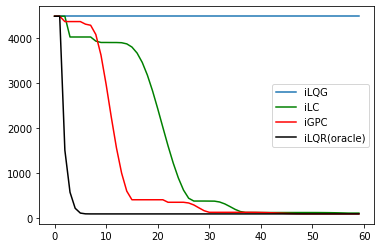

In [10]:
import matplotlib.pyplot as plt
from deluca.igpc.plot_utils import process_for_plot, zero_cost

iLC_perf = process_for_plot(str(iLC_output.stdout), 60)
iGPC_perf = process_for_plot(str(iGPC_output.stdout), 60)
iLQRO_perf = process_for_plot(str(iLQRO_output.stdout), 60)
iLQG_cost = zero_cost(str(iLC_output.stdout))

plt.plot(list(range(60)), [iLQG_cost]*60, label='iLQG')
plt.plot(iLC_perf[0], iLC_perf[1], 'green', label='iLC')
plt.plot(iGPC_perf[0], iGPC_perf[1], 'red', label='iGPC')
plt.plot(iLQRO_perf[0], iLQRO_perf[1], 'black', label='iLQR(oracle)')
plt.legend()